In [1]:
import sys
import pandas as pd
import numpy as np
import requests
import json
from decimal import Decimal
import matplotlib.pyplot as plt
import scipy.stats as ss
from uniswap import get_input_price, get_output_price, buy_to_price
from graph_util import fetch_safes, fetch_rp

import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 

## Overview

Explore how system liquidation_ratios affect how much bad debt is created during ETH/USD price dops.

## Methodology

Simulate an ETH/USD price drop of X%, then use RAI from Uniswap pools to settle resulting collateral auctions. 

## Simulations

1) Using mainnet collateral amounts and c-ratios

2) Use mainnet collateral amounts and stochastic c-ratios

3) Use stochastic collateral amounts and stochastic c-ratios


## Pessimistic Assumptions
### - All RAI for collateral auctions will come from pools. No RAI-holding keepers bid on auctions
### - No opposing market forces to push market back towards redemption price when keepers purchase RAI
### - 20% of critical SAFEs react to OSM price and avoid liquidation
### - RAI maintains market_price = redemption_price on eth shock
### - Saviours not considered


## Optimistic Assumptions
### - **Pool liquidity is not reduced during ETH shock**
### - Gas price is ot considered
### - Surplus buffer not considered, so no surplus auctions,

Fetch ETH/USD price, redemption price and all Reflexer SAFEs

In [3]:
#graphql_url = 'https://subgraph.reflexer.finance/subgraphs/name/reflexer-labs/rai'
graphql_url = 'https://api.thegraph.com/subgraphs/name/reflexer-labs/rai-mainnet'
eth_usd_url = 'https://api.coingecko.com/api/v3/simple/price?ids=ethereum&vs_currencies=usd'
ETH_USD = requests.get(eth_usd_url).json()['ethereum']['usd']
REDEMPTION_PRICE = fetch_rp(graphql_url)
orig_safes = fetch_safes(graphql_url)

# only consider SAFEs with debt
orig_safes = orig_safes.query('debt > 0').reset_index()

Mainnet Parameters

In [4]:
MAINNET_LIQ_RATIO = 1.40 
LIQ_PENALTY = 1.10
INITIAL_SURPLUS = 493000
MIN_DISCOUNT = 0.92
MAX_DISCOUNT = 0.90
# use max_discount for collateral_auctions
DISCOUNT = MAX_DISCOUNT
OSM_RESPONSIVENESS = 0.20 # What percent of SAFE owners use OSM to avoid liquidation

# RAI pools
RAI_ETH_V2= 7.1E6
RAI_ETH_V3 = 58E3 
RAI_DAI_V3 = 4E6 
RAI_USDC_V3 = 1E6 

rai_v2_pool = RAI_ETH_V2 + RAI_ETH_V3
usd_v2_pool = rai_v2_pool * REDEMPTION_PRICE
rai_v3_pool = RAI_DAI_V3 + RAI_USDC_V3
usd_v3_pool = rai_v3_pool * REDEMPTION_PRICE

SURPLUS_BUFFER = 500000 # Not currently used
DISCOUNT_UPDATE_RATE = Decimal(0.999991859697312485818842992) # Not currently used
LIQUIDATION_QUANTITY = 90000.00 # Not currently used
ON_AUCTION_SYSTEM_COIN_LIMIT = 4025086.73 # Not currently used

In [5]:
def update_cratios(safes, eth_price, redemption_price):
    # update c-ratio based on `eth_price` and `redemption_price`
    new_safes = safes.copy()
    new_safes['cratio'] = new_safes['collateral'] * eth_price / (new_safes['debt'] * redemption_price)
    return new_safes

In [6]:
def liquidate_critical(safes, liq_cratio=1.40):
    # Return amount of collateral/debt liquidated
    critical_safes = safes.query(f'cratio < {liq_cratio}')

    critical_collateral = critical_safes['collateral'].sum()
    critical_debt = critical_safes['debt'].sum()

    return critical_collateral, critical_debt

def adjust_safe_debt_and_cratios(safes, debt_adj, eth_price, redemption_price):
    # adjust debt by `debt_adj` multiplier
    if debt_adj == 1:
        return safes
    new_safes = safes.copy()
    
    new_safes['debt'] *= debt_adj

    return update_cratios(new_safes, eth_price, redemption_price)

In [7]:
def run(orig_safes, liq_ratio, shock, current_surplus):
    
    # `debt_adj` is used to adjust individual SAFE debt to match expected values when liq_ratio is changed
    # This preserves safe debt as a multiplier of liq_ratio
    debt_adj =  MAINNET_LIQ_RATIO/ liq_ratio
    safes = adjust_safe_debt_and_cratios(orig_safes, debt_adj, ETH_USD, REDEMPTION_PRICE)
    
    # Set eth shock price
    eth_shock_price = ETH_USD * (1 - shock)
    
    # update c-ratios
    safes = update_cratios(safes, eth_shock_price, REDEMPTION_PRICE)

    # Liquidate all critical SAFEs
    critical_collateral, critical_debt = liquidate_critical(safes, liq_ratio)
    
    critical_collateral *= (1 - OSM_RESPONSIVENESS)
    critical_debt *= (1 - OSM_RESPONSIVENESS)
    

    amount_to_raise = critical_debt * LIQ_PENALTY
    discount_collateral_price = eth_shock_price * DISCOUNT
    
    total_collateral_cost = critical_collateral * discount_collateral_price
    
    # Use v3 pool 
    # Assume rai market = redemption price and estimate slippage
    rai_v3_market_price = REDEMPTION_PRICE * 1.005 # Estimate slippage in V3 pool.

    # Use up to the entire pool to buy discounted collateral
    v3_collateral_bought = min((rai_v3_pool * REDEMPTION_PRICE)/discount_collateral_price, critical_collateral) 

    collateral_left = critical_collateral - v3_collateral_bought

    rai_v3_spent = v3_collateral_bought * discount_collateral_price / REDEMPTION_PRICE

    amount_raised_v3 = rai_v3_spent

    if collateral_left == 0:
        amount_deficit = critical_debt - amount_raised_v3
    
    else: # Then use V2 pool

        amount_left_to_raise = amount_to_raise - rai_v3_spent

        collateral_left_cost = collateral_left * discount_collateral_price

        # max price to pay for RAI to make a profit on discounted collateral
        max_market_price = REDEMPTION_PRICE / DISCOUNT

        # Max amount to buy to put cost-basis at `max_market_price`
        how_much_v2_can_buy = 2 * buy_to_price(None, rai_v2_pool, goal_price=max_market_price, market_price=REDEMPTION_PRICE)

        # how is the pool affected when with this swap
        # This just confirms the expected final market price
        #delta_usd, delta_rai = get_output_price(how_much_v2_can_buy, usd_v2_pool, rai_v2_pool, trade_fee=0.003)
        # new market price
        #print(f"market price after buy {(usd_v2_pool + delta_usd)/(rai_v2_pool + delta_rai):.2f}")

        amount_raised_v2 = min(amount_left_to_raise, how_much_v2_can_buy)

        amount_deficit = critical_debt - amount_raised_v2 - amount_raised_v3

    return INITIAL_SURPLUS - amount_deficit

### Simulate eth shocks using current mainnet collateral and c-ratios

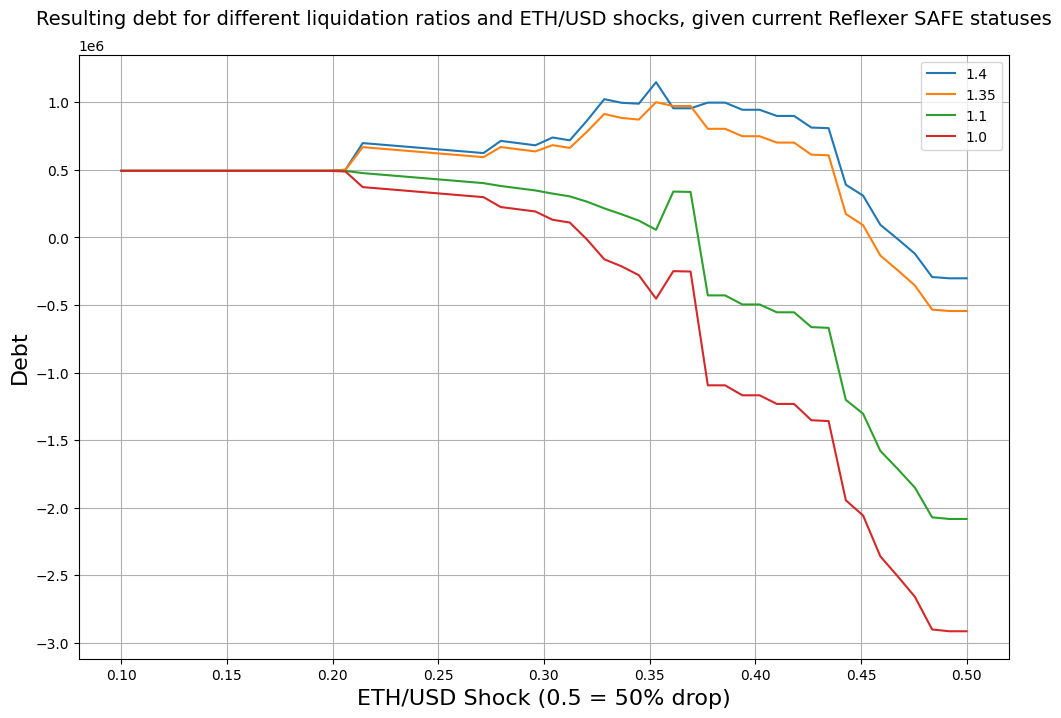

In [8]:
liq_ratios = [1.40, 1.35, 1.10, 1.0]
all_shocks = np.linspace(0.1, 0.5, 50)

for lr in liq_ratios:    
    lr_shocks = []
    lr_surpluses = []
    for s in all_shocks:
        surplus = run(orig_safes, lr, s, INITIAL_SURPLUS)
        lr_shocks.append(s)
        lr_surpluses.append(surplus)
    plt.plot(lr_shocks, lr_surpluses, label=lr)
    
plt.legend()
plt.title('Resulting debt for different liquidation ratios and ETH/USD shocks, given current Reflexer SAFE statuses\n', fontsize=14)
plt.xlabel('ETH/USD Shock (0.5 = 50% drop)', fontsize=16)
plt.ylabel('Debt', fontsize=16)
plt.grid(True)
plt.show()

### Existing SAFE C-ratios

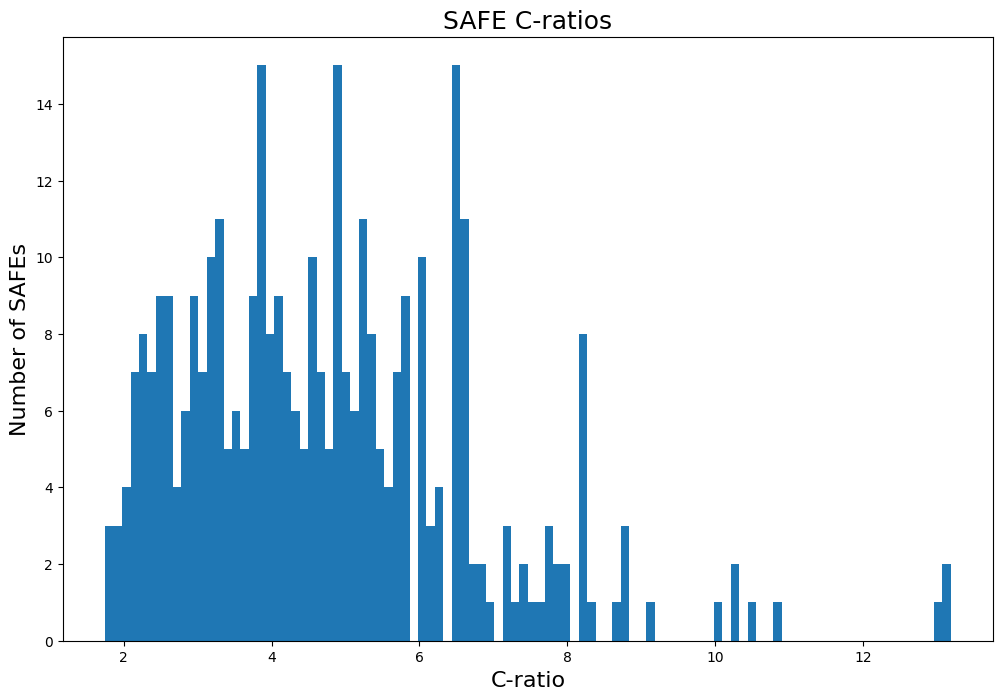

In [9]:
orig_safes = update_cratios(orig_safes, ETH_USD, REDEMPTION_PRICE)
orig_safes['cratio'].hist(bins=100)
plt.title('SAFE C-ratios', fontsize=18)
plt.xlabel('C-ratio', fontsize=16)
plt.ylabel('Number of SAFEs', fontsize=16)
plt.grid(False)
plt.show()

Fit a normal distribution to c-ratios, but it's not a great fit

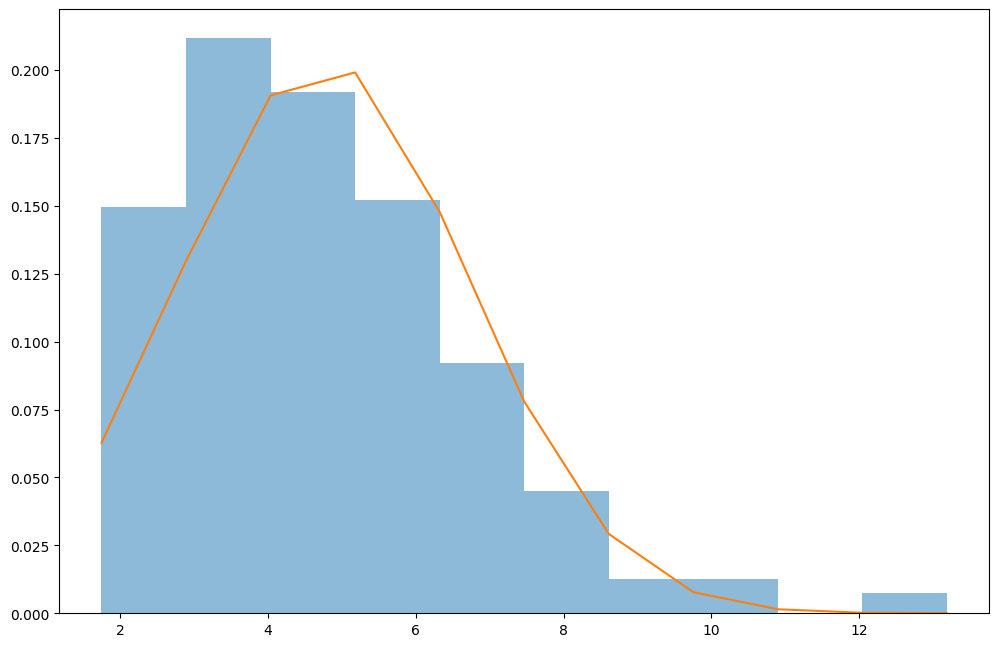

In [10]:
_, bins, _ = plt.hist(orig_safes['cratio'], 10, density=1, alpha=0.5)
mu, sigma = ss.norm.fit(orig_safes['cratio'])
best_fit_line = ss.norm.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line)
plt.show()

### Use fitter to try many distributions and then pick the best one and its params

/Users/georgekellerman/github/geb-data-science/venv/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


,sumsquare_error,aic,bic,kl_div
burr,0.355585,677.369940,-2396.623791,inf
mielke,0.355589,677.430399,-2396.619414,inf
chi,0.360054,681.447662,-2398.100318,inf
nakagami,0.360055,681.439148,-2398.099718,inf
gengamma,0.364208,669.822200,-2388.213542,inf


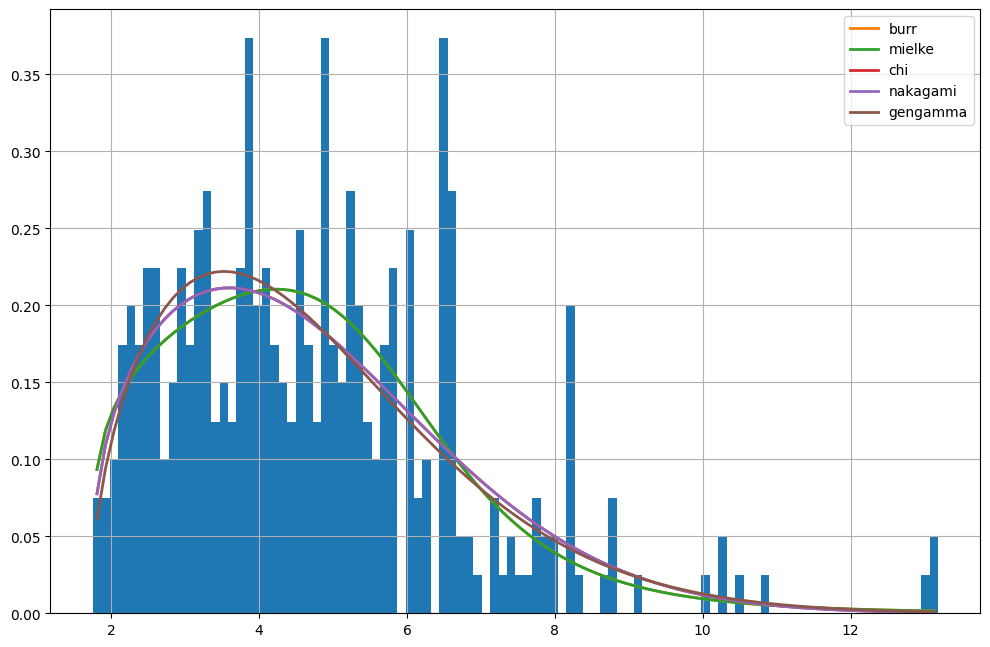

In [11]:
fitter_cratio = Fitter(orig_safes['cratio'].values)          
fitter_cratio.fit()
fitter_cratio.summary()

### Pick the best distribution and generate some c-ratios from it using the fitted parameters

In [12]:
# best_cratio = fitter_cratio.get_best(method = 'sumsquare_error')
cratio_params = fitter_cratio.fitted_param["mielke"]

/Users/georgekellerman/github/geb-data-science/venv/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


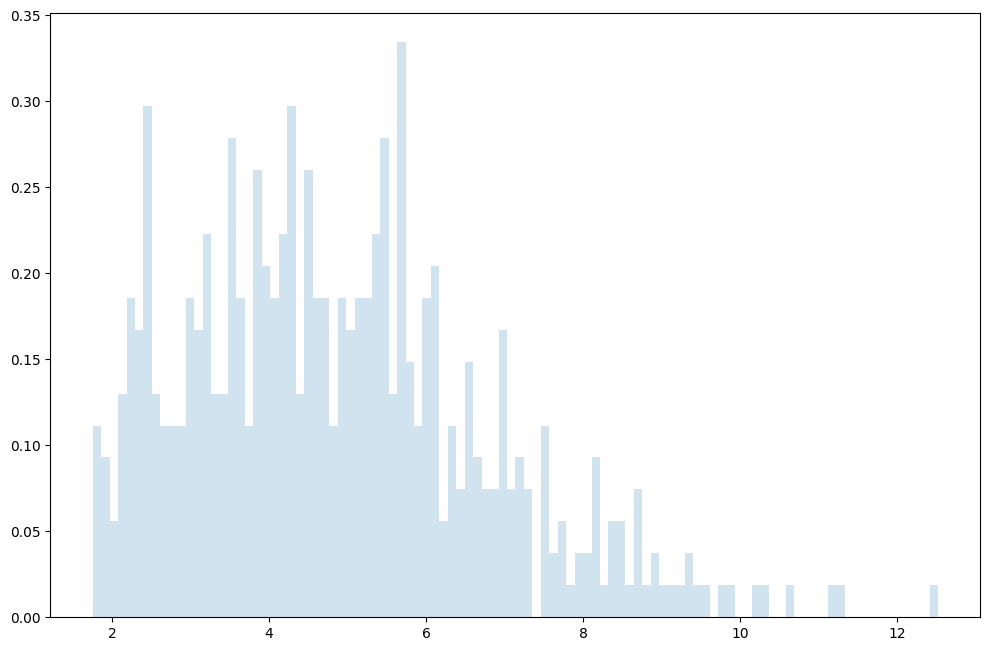

In [13]:
cratios_r = ss.mielke.rvs(*cratio_params, size=500)
plt.hist(cratios_r, density=True, histtype='stepfilled', bins=100, alpha=0.2)
plt.show()

### Simulate eth shocks using mainnet SAFE collateral amounts and stochastic c-ratios

/Users/georgekellerman/github/geb-data-science/venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:4837: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


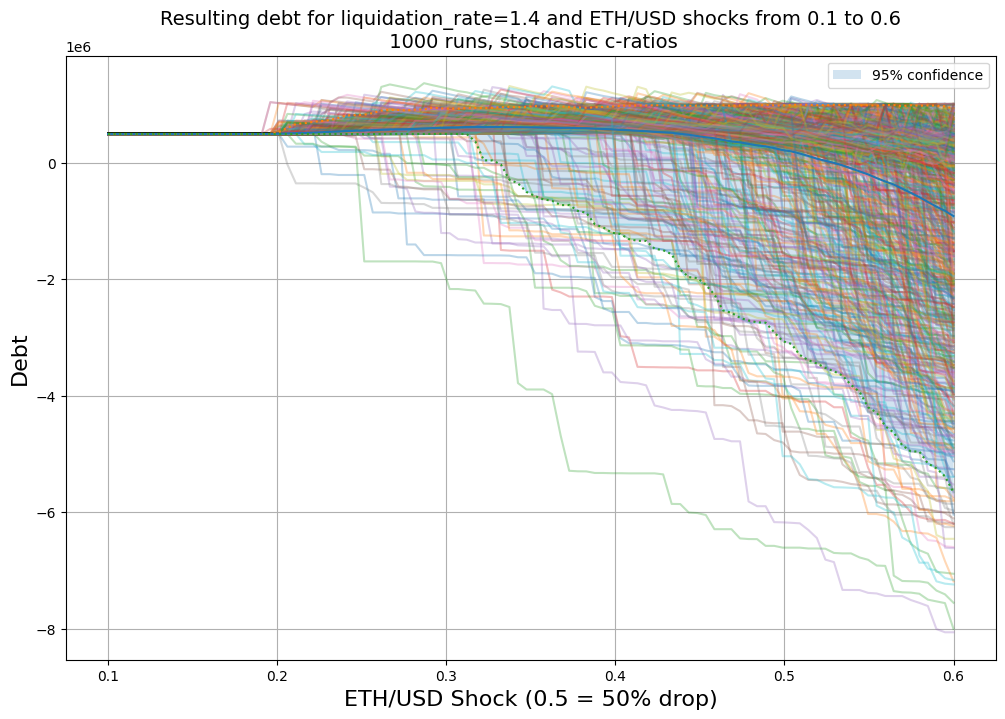

In [14]:
all_shocks = []
all_surplus = []
n_std = 2.0
min_shock = 0.1
max_shock = 0.6
shocks = np.linspace(min_shock, max_shock, 100)
lr = 1.40
n_runs = 1000
for i in range(n_runs):
    cratios = ss.mielke.rvs(*cratio_params, size=len(orig_safes)-1)
    tmp_safes = pd.DataFrame([])   
    tmp_safes['cratio'] = cratios

    #tmp_safes['collateral'] = orig_safes.query('collateral < 10000000').reset_index()['collateral']
    tmp_safes['collateral'] = orig_safes['collateral']
    
    tmp_safes['debt'] = tmp_safes['collateral'] * ETH_USD / REDEMPTION_PRICE / tmp_safes['cratio']

    lr_shocks = []
    lr_surpluses = []
    for s in shocks:
        surplus = run(tmp_safes, lr, s, INITIAL_SURPLUS)
        lr_shocks.append(s)
        lr_surpluses.append(surplus)

        all_shocks.append(s)
        all_surplus.append(surplus)

    plt.plot(lr_shocks, lr_surpluses, alpha=0.3)
        
# plot mean
df = pd.DataFrame({'shock': all_shocks,  'surplus': all_surplus})
df_mean = df.groupby('shock').mean().reset_index()
plt.plot(df_mean['shock'], df_mean['surplus'])

df_975 = df.groupby('shock').quantile(0.975).reset_index()
df_025 = df.groupby('shock').quantile(0.025).reset_index()
plt.plot(df_mean['shock'], df_975['surplus'], ':')
plt.plot(df_mean['shock'], df_025['surplus'], ':')

plt.fill_between(shocks, 
                df_975['surplus'], 
                df_025['surplus'], alpha=0.2, label="95% confidence")


plt.title(f'Resulting debt for liquidation_rate={lr} and ETH/USD shocks from {min_shock} to {max_shock}\n {n_runs} runs, stochastic c-ratios', fontsize=14)
plt.xlabel('ETH/USD Shock (0.5 = 50% drop)', fontsize=16)
plt.ylabel('Debt', fontsize=16)
plt.grid(True)
plt.legend()
plt.show()

### Simulate eth shocks using stochastic SAFE collateral amounts and stochastic c-ratios

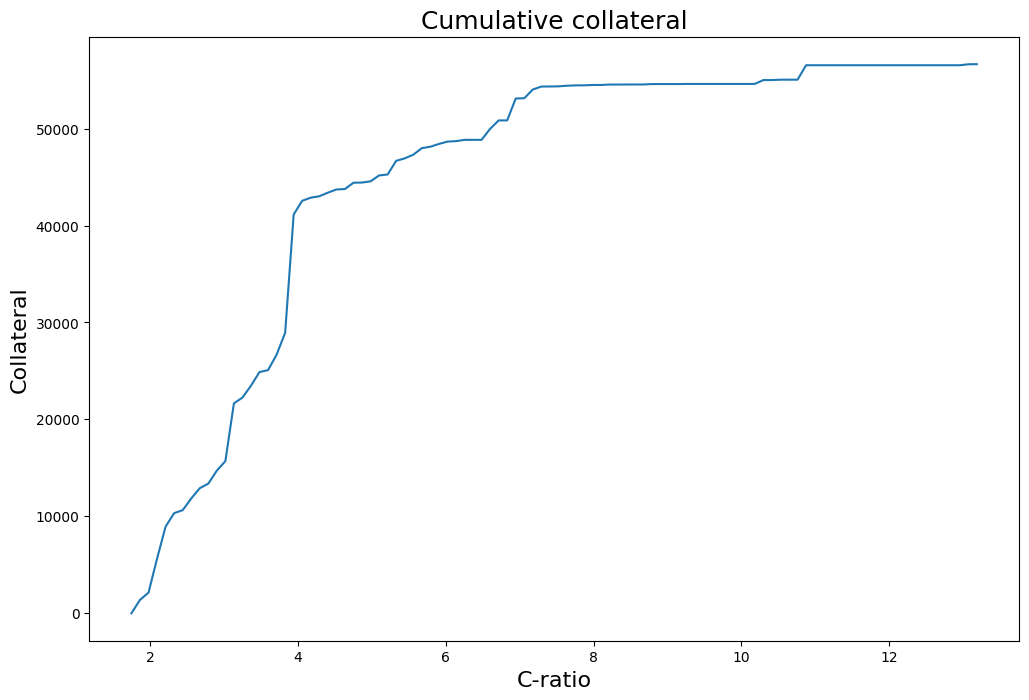

In [15]:
def plot_cumulative_coll_cratios(safes):
    min_cratio = min(safes['cratio'])
    max_cratio = max(safes['cratio'])

    bins = 100
    cratios = [] 
    coll = []
    for cratio in np.linspace(min_cratio, max_cratio, bins):
        cratios.append(cratio)
        coll.append(safes.query(f'cratio < {cratio}')['collateral'].sum())

    plt.plot(cratios, coll)
    plt.title('Cumulative collateral', fontsize=18)
    plt.xlabel('C-ratio', fontsize=16)
    plt.ylabel('Collateral', fontsize=16)
    plt.show()
    
plot_cumulative_coll_cratios(orig_safes)  

### Now fit the distribution of collateral

/Users/georgekellerman/github/geb-data-science/venv/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


,sumsquare_error,aic,bic,kl_div
gilbrat,0.000003,4080.608601,-6497.458785,inf
wald,0.000006,6162.881773,-6263.612120,inf
beta,0.000007,13989.027431,-6194.418332,inf
exponnorm,0.000017,7270.186349,-5901.320700,inf
genexpon,0.000017,7259.455388,-5888.776653,inf


/Users/georgekellerman/github/geb-data-science/venv/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


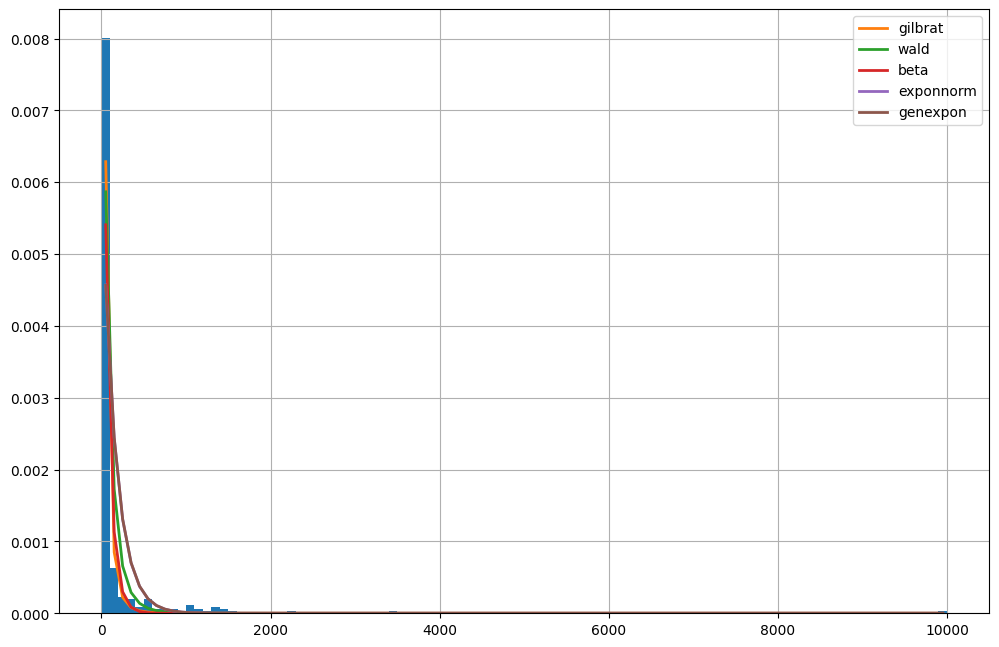

In [16]:
fitter_coll = Fitter(orig_safes['collateral'].values)          
fitter_coll.fit()
fitter_coll.summary()

### Pick the best fitting distribution and generate some samples from it

In [17]:
#best_coll = fitter_coll.get_best(method = 'sumsquare_error')
coll_params = fitter_coll.fitted_param["gilbrat"]

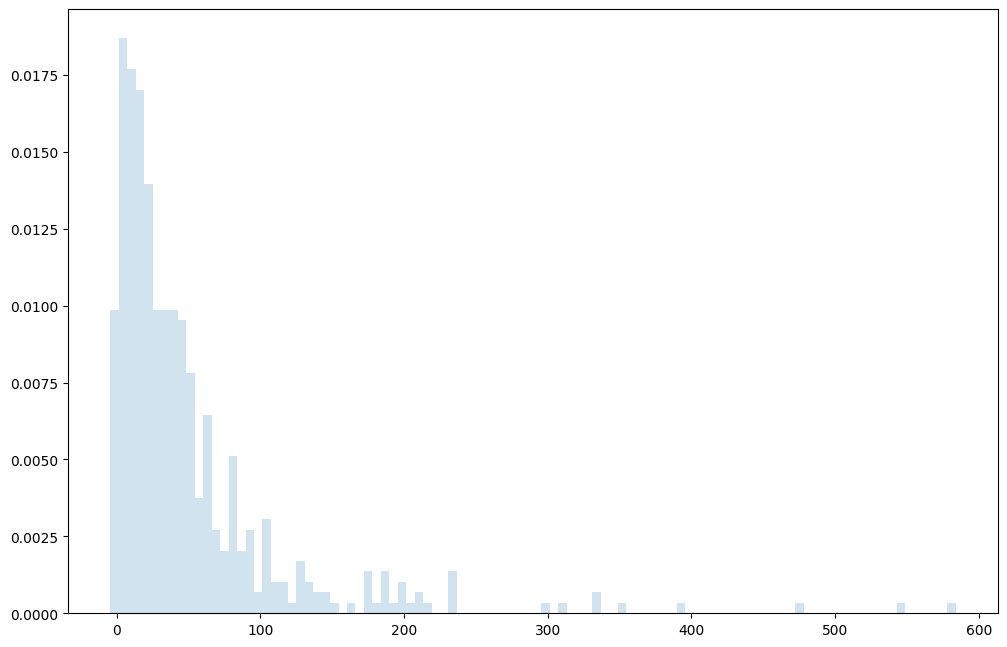

In [18]:
colls_r = ss.gilbrat.rvs(*coll_params, size=500)
plt.hist(colls_r, density=True, histtype='stepfilled', bins=100, alpha=0.2)
plt.show()

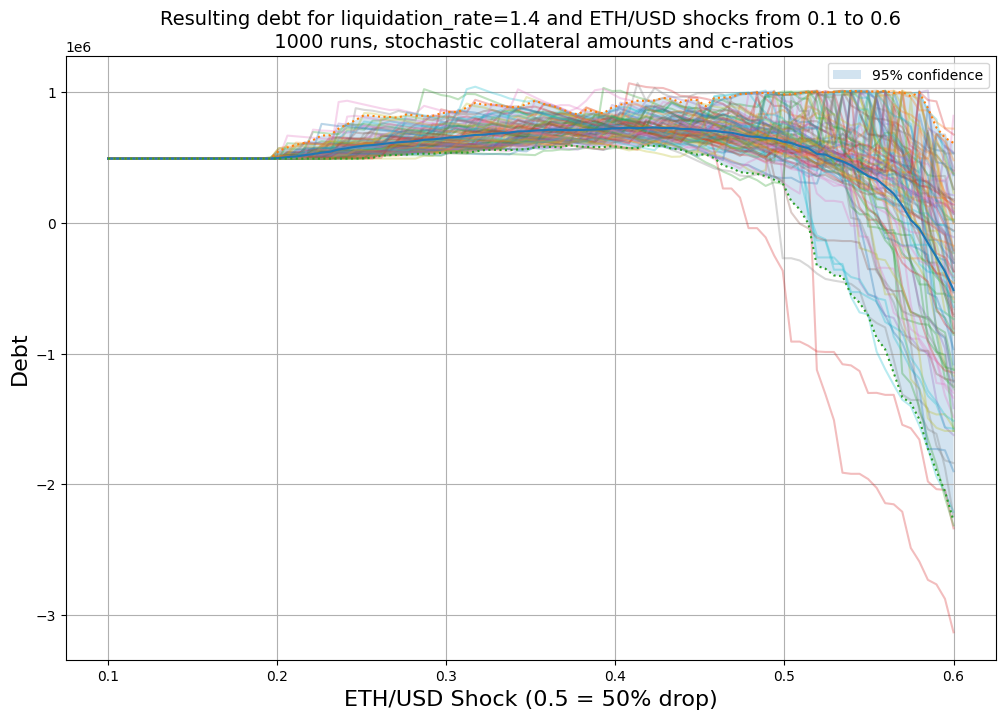

In [19]:
all_shocks = []
all_surplus = []
n_std = 2.0
shocks = np.linspace(0.1, 0.6, 100)
lr = 1.40
for i in range(100):
    cratios = ss.mielke.rvs(*cratio_params, size=len(orig_safes))
    tmp_safes = pd.DataFrame([])
    tmp_safes['cratio'] = cratios
    tmp_safes['collateral'] = ss.gilbrat.rvs(*coll_params, size=len(orig_safes))   
    
    # match sum of collateral to mainnet sum
    tmp_safes['collateral'] *= orig_safes['collateral'].sum() / tmp_safes['collateral'].sum()
    
    tmp_safes['debt'] = tmp_safes['collateral'] * ETH_USD / REDEMPTION_PRICE / tmp_safes['cratio']
    

    lr_shocks = []
    lr_surpluses = []
    
    for s in shocks:
        surplus = run(tmp_safes, lr, s, INITIAL_SURPLUS)
        lr_shocks.append(s)
        lr_surpluses.append(surplus)

        all_shocks.append(s)
        all_surplus.append(surplus)

    plt.plot(lr_shocks, lr_surpluses, alpha=0.3)
        
# plot mean
df = pd.DataFrame({'shock': all_shocks,  'surplus': all_surplus})
df_mean = df.groupby('shock').mean().reset_index()
plt.plot(df_mean['shock'], df_mean['surplus'])

# plot std and fill between
df_975 = df.groupby('shock').quantile(0.975).reset_index()
df_025 = df.groupby('shock').quantile(0.025).reset_index()
plt.plot(df_mean['shock'], df_975['surplus'], ':')
plt.plot(df_mean['shock'], df_025['surplus'], ':')
plt.fill_between(shocks, 
                df_975['surplus'], 
                df_025['surplus'], alpha=0.2,label="95% confidence")

plt.title(f'Resulting debt for liquidation_rate={lr} and ETH/USD shocks from {min_shock} to {max_shock}\n {n_runs} runs, stochastic collateral amounts and c-ratios', fontsize=14)
plt.xlabel('ETH/USD Shock (0.5 = 50% drop)', fontsize=16)
plt.ylabel('Debt', fontsize=16)
plt.grid(True)
plt.legend()
plt.show()

In [20]:
%pip install -q sklearn

You should consider upgrading via the '/Users/georgekellerman/github/geb-data-science/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Fit Gaussian Mixture Model to SAFE collateral and c-ratio

/var/folders/z_/tzvx3mfs7rsbb8dxt0rd157w0000gn/T/ipykernel_20101/4074893223.py:22: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  CB = plt.colorbar(CS, shrink=0.8, extend='both')


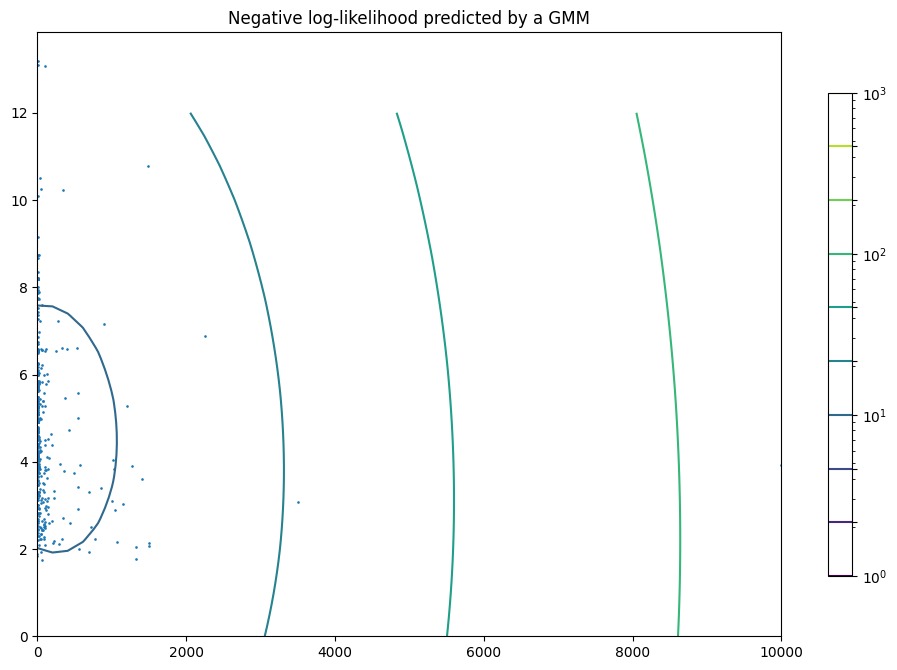

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=1, covariance_type='full')
clf.fit(orig_safes[['collateral', 'cratio']])

r = np.random.multivariate_normal(clf.means_[0], clf.covariances_[0], 10000)

# display predicted scores by the model as a contour plot
x = np.linspace(0, 10000.)
y = np.linspace(0, 12.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(orig_safes['collateral'], orig_safes['cratio'], .8)

#plt.scatter(r[:,0], r[:,1], .8)

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()


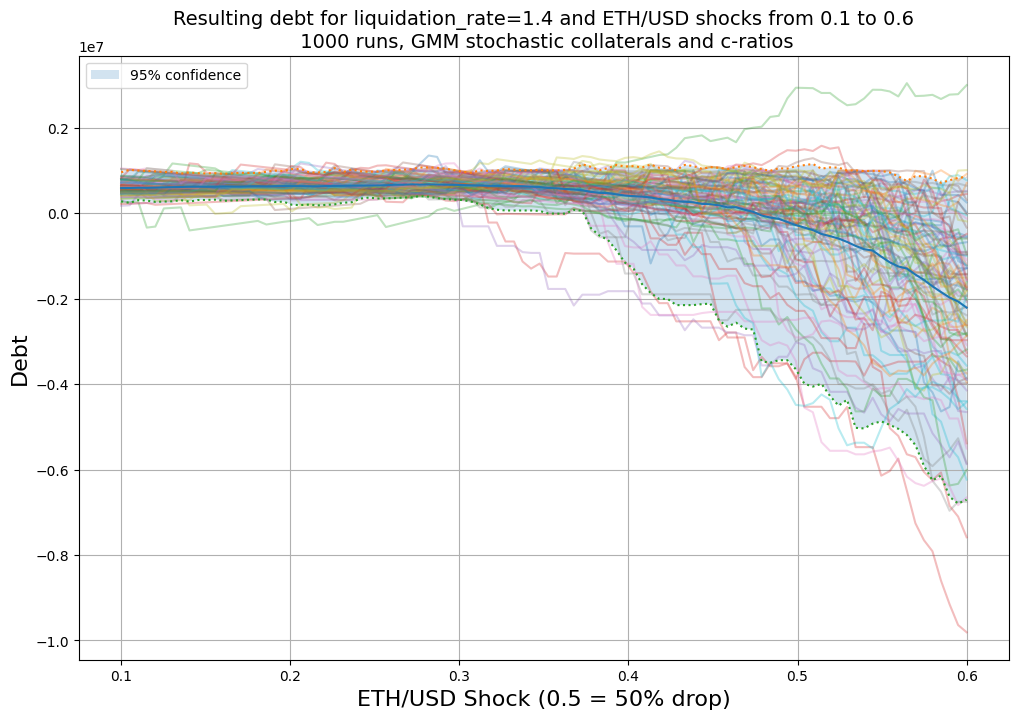

In [22]:
all_shocks = []
all_surplus = []
n_std = 2.0
shocks = np.linspace(0.1, 0.6, 100)
lr = 1.40
for i in range(100):
    r = np.random.multivariate_normal(clf.means_[0], clf.covariances_[0], 10000)
    gaussian_safes = r[r[:,1] > MAINNET_LIQ_RATIO]
    gaussian_safes = gaussian_safes[:len(orig_safes)]
    tmp_safes  = pd.DataFrame({"collateral": gaussian_safes[:,0], 'cratio': gaussian_safes[:,1]})
    
    # match sum of collateral to mainnet sum
    tmp_safes['collateral'] *= orig_safes['collateral'].sum() / tmp_safes['collateral'].sum()
    
    tmp_safes['debt'] = tmp_safes['collateral'] * ETH_USD / REDEMPTION_PRICE / tmp_safes['cratio']
    
    lr_shocks = []
    lr_surpluses = []
    
    for s in shocks:
        surplus = run(tmp_safes, lr, s, INITIAL_SURPLUS)
        lr_shocks.append(s)
        lr_surpluses.append(surplus)

        all_shocks.append(s)
        all_surplus.append(surplus)

    plt.plot(lr_shocks, lr_surpluses, alpha=0.3)
        
# plot mean
df = pd.DataFrame({'shock': all_shocks,  'surplus': all_surplus})
df_mean = df.groupby('shock').mean().reset_index()
plt.plot(df_mean['shock'], df_mean['surplus'])

# plot std and fill between
df_975 = df.groupby('shock').quantile(0.975).reset_index()
df_025 = df.groupby('shock').quantile(0.025).reset_index()
plt.plot(df_mean['shock'], df_975['surplus'], ':')
plt.plot(df_mean['shock'], df_025['surplus'], ':')
plt.fill_between(shocks, 
                df_975['surplus'], 
                df_025['surplus'], alpha=0.2,label="95% confidence")


plt.title(f'Resulting debt for liquidation_rate={lr} and ETH/USD shocks from {min_shock} to {max_shock}\n {n_runs} runs, GMM stochastic collaterals and c-ratios', fontsize=14)
plt.xlabel('ETH/USD Shock (0.5 = 50% drop)', fontsize=16)
plt.ylabel('Debt', fontsize=16)
plt.grid(True)
plt.legend()
plt.show()